In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import torch
import torch.nn as nn
import re
from utils_notebook import histogram_experiment, dataframe_to_latex

In [2]:
results_path = "../results/all_db_all_training"
full_results_df = pd.DataFrame()

In [3]:
# For all folder in results_path
for experiment_folder in os.listdir(results_path):
    # Load the data
    # if experiment starts with DDPM skip
    if experiment_folder.startswith("DDPM"):
        continue
    if "exponential" in experiment_folder or "cosine" in experiment_folder:
            continue
    for dataset_folder in os.listdir(os.path.join(results_path, experiment_folder)):
        if "A_synthetic" not in dataset_folder:
            continue
        try:
            dataset_results = pd.read_csv(Path(results_path, experiment_folder,dataset_folder, "model_metrics.csv"))
        except Exception as e:
            print(f"Error loading {results_path}/{experiment_folder}/{dataset_folder}/model_metrics.csv")
            print(e)
            continue
        
        dataset_results["experiment"] = experiment_folder
        dataset_results["dataset_name"] = "_".join(dataset_folder.split("_")[:-2])
        dataset_results['dataset_version'] = dataset_folder.split("_")[-1]
        dataset_results['nb_bins'] = int(re.search(r"bins(\d+)", experiment_folder).group(1))
        dataset_results['T'] = int(re.search(r"T(\d+)", experiment_folder).group(1))
        full_results_df = pd.concat([full_results_df, dataset_results])


In [4]:
full_results_df = full_results_df.drop(columns=["Unnamed: 0", "model_name", "sampling_method"], )
full_results_df.head()

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,nb_bins,T
0,1625.229563,0.234861,0.524000,A_synthetic_f4_s5000_c2_r0.05_0.05,DSIL,0,0.763793,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,400
0,1606.305507,0.240988,0.890000,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,DSIL,0,0.989764,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,5,7,400
0,1598.099334,0.245115,0.658586,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033,DSIL,0,0.890196,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,2,7,400
0,1397.762980,0.169002,0.858000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.935408,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,3,7,400
0,1434.482876,0.140135,0.856000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.934186,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,400


In [5]:
for name in full_results_df.columns:
    print(name)

training_time
inference_time
f1_score
dataset_name
training_method
random_seed
aucroc
experiment
dataset_version
nb_bins
T


In [6]:

# RAtio are stored in the string as r{ratio1}_{ratio2}_..._{ratioN}
ratios = full_results_df['dataset_name'].str.extract(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)')
# Remove empty ratio
# Combine the two capture groups and drop NaNs
ratios = ratios.apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1).astype(float)

# Sum the ratios grouped by the dataset index
full_results_df['anomaly_ratio'] = ratios.groupby(level=0).sum()

In [7]:
full_results_df

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,nb_bins,T,anomaly_ratio
0,1625.229563,0.234861,0.524000,A_synthetic_f4_s5000_c2_r0.05_0.05,DSIL,0,0.763793,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,400,2.6552
0,1606.305507,0.240988,0.890000,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,DSIL,0,0.989764,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,5,7,400,2.6552
0,1598.099334,0.245115,0.658586,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033,DSIL,0,0.890196,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,2,7,400,2.6552
0,1397.762980,0.169002,0.858000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.935408,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,3,7,400,2.6552
0,1434.482876,0.140135,0.856000,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,0,0.934186,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,7,400,2.6552
...,...,...,...,...,...,...,...,...,...,...,...,...
0,524.740895,0.234187,0.692000,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,unsupervised,0,0.911093,DTEC_unsupervised_None_s0_T400_bins7,3,7,400,2.6552
0,539.660847,0.206802,0.700000,A_synthetic_f4_s5000_c2_r0.025_0.025,unsupervised,0,0.917133,DTEC_unsupervised_None_s0_T400_bins7,5,7,400,2.6552
0,532.821296,0.236527,0.568000,A_synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01...,unsupervised,0,0.861925,DTEC_unsupervised_None_s0_T400_bins7,3,7,400,2.6552
0,516.809376,0.218475,0.715152,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033,unsupervised,0,0.906662,DTEC_unsupervised_None_s0_T400_bins7,1,7,400,2.6552


In [8]:
full_results_df['dimension'] = full_results_df['dataset_name'].str.extract(r"f(\d+)", expand=False).astype(int)

# Compute mean and std for each dataset with different version, but same experiment name
temp_df = full_results_df.drop(columns=["dataset_version"])
temp_df['anomaly_ratio']
mean_df = temp_df.groupby(["experiment", "dataset_name", 'training_method', 'T', 'nb_bins']).mean().reset_index()
std_df = temp_df.groupby(["experiment", "dataset_name", "training_method", 'T', 'nb_bins']).std().reset_index()


In [9]:
mean_df.head()

,experiment,dataset_name,training_method,T,nb_bins,training_time,inference_time,f1_score,random_seed,aucroc,anomaly_ratio,dimension
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,400,7,1518.307022,0.159044,0.771000,0.0,0.883443,2.6552,1000.0
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,400,7,1507.935709,0.153931,0.744667,0.0,0.881237,2.6552,1000.0
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,400,7,1444.464144,0.142122,0.860333,0.0,0.940816,2.6552,1000.0
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.0...,DSIL,400,7,1625.181474,0.233139,0.795333,0.0,0.952058,2.6552,100.0
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,DSIL,400,7,1605.106977,0.225388,0.785667,0.0,0.936794,2.6552,100.0


In [10]:
std_df.head()

,experiment,dataset_name,training_method,T,nb_bins,training_time,inference_time,f1_score,random_seed,aucroc,anomaly_ratio,dimension
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,400,7,6.947477,0.013930,0.017088,0.0,0.014430,0.0,0.0
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,400,7,18.815693,0.032906,0.028780,0.0,0.023561,0.0,0.0
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,400,7,41.493313,0.025924,0.013823,0.0,0.009936,0.0,0.0
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.0...,DSIL,400,7,13.908574,0.035948,0.014180,0.0,0.005224,0.0,0.0
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,DSIL,400,7,14.580374,0.016176,0.015253,0.0,0.011058,0.0,0.0


In [11]:
print(full_results_df['experiment'].unique())
print(full_results_df['dataset_name'].unique())

['DTEC_DSIL_deterministic_0.5_s0_T400_bins7'
 'DTEC_unsupervised_None_s0_T400_bins7']
['A_synthetic_f4_s5000_c2_r0.05_0.05'
 'A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02_0.02'
 'A_synthetic_f10_s5000_c4_r0.033_0.033_0.033'
 'A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0.02_0.02'
 'A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0.01_0.01'
 'A_synthetic_f10_s5000_c4_r0.0166_0.0166_0.0166'
 'A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.02_0.02'
 'A_synthetic_f4_s5000_c2_r0.025_0.025'
 'A_synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01_0.01'
 'A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0.01_0.01'
 'A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_0.01']


In [12]:
mean_df.head()

,experiment,dataset_name,training_method,T,nb_bins,training_time,inference_time,f1_score,random_seed,aucroc,anomaly_ratio,dimension
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,400,7,1518.307022,0.159044,0.771000,0.0,0.883443,2.6552,1000.0
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,400,7,1507.935709,0.153931,0.744667,0.0,0.881237,2.6552,1000.0
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,400,7,1444.464144,0.142122,0.860333,0.0,0.940816,2.6552,1000.0
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.0...,DSIL,400,7,1625.181474,0.233139,0.795333,0.0,0.952058,2.6552,100.0
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,DSIL,400,7,1605.106977,0.225388,0.785667,0.0,0.936794,2.6552,100.0


In [14]:
unsup_bin_mean_df = mean_df
unsup_bin_mean_df = unsup_bin_mean_df[unsup_bin_mean_df['T'] == 400]
unsup_bin_std_df = std_df
unsup_bin_std_df = unsup_bin_std_df[unsup_bin_std_df['T'] == 400]

In [15]:
unsup_bin_mean_df.head()

,experiment,dataset_name,training_method,T,nb_bins,training_time,inference_time,f1_score,random_seed,aucroc,anomaly_ratio,dimension
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c12_r0.01_0.01_0.01_0....,DSIL,400,7,1518.307022,0.159044,0.771000,0.0,0.883443,2.6552,1000.0
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.01_0.01_0.01_0....,DSIL,400,7,1507.935709,0.153931,0.744667,0.0,0.881237,2.6552,1000.0
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,400,7,1444.464144,0.142122,0.860333,0.0,0.940816,2.6552,1000.0
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.0...,DSIL,400,7,1625.181474,0.233139,0.795333,0.0,0.952058,2.6552,100.0
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,DSIL,400,7,1605.106977,0.225388,0.785667,0.0,0.936794,2.6552,100.0


In [16]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(unsup_bin_mean_df, unsup_bin_std_df, on=["experiment", "dataset_name", "T", "nb_bins"], suffixes=('_mean', '_std'))

# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"{row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})", axis=1
)
merged_df['aucroc_str'] = merged_df.apply(
    lambda row: f"{row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})", axis=1
)


In [17]:
# Define a function to extract and sum all ratios from the dataset name
def extract_ratios(dataset_name):
    # Use re.findall to capture all numerical ratios
    ratios = re.findall(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)', dataset_name)
    # Flatten the list of tuples and filter out empty strings
    ratios = [float(r) for pair in ratios for r in pair if r]
    # Return the sum of the ratios
    return f"{sum(ratios) * 100:.2f}"
def rename_row(dataset_name):
    return "synthetic {} - {}".format(re.search(r"f(\d+)", dataset_name).group(1), extract_ratios(dataset_name))
# In dataset name, keep only the word "synthetic" and the number of feature which is after "f_"ArithmeticError
merged_df['dataset_name'] = merged_df['dataset_name'].apply(rename_row)


In [18]:
merged_df.head()

,experiment,dataset_name,training_method_mean,T,nb_bins,training_time_mean,inference_time_mean,f1_score_mean,random_seed_mean,aucroc_mean,...,training_method_std,training_time_std,inference_time_std,f1_score_std,random_seed_std,aucroc_std,anomaly_ratio_std,dimension_std,f1_score_str,aucroc_str
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,synthetic 1000 - 5.00,DSIL,400,7,1518.307022,0.159044,0.771000,0.0,0.883443,...,DSIL,6.947477,0.013930,0.017088,0.0,0.014430,0.0,0.0,0.77(0.02),0.88(0.01)
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,synthetic 1000 - 5.00,DSIL,400,7,1507.935709,0.153931,0.744667,0.0,0.881237,...,DSIL,18.815693,0.032906,0.028780,0.0,0.023561,0.0,0.0,0.74(0.03),0.88(0.02)
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,synthetic 1000 - 10.00,DSIL,400,7,1444.464144,0.142122,0.860333,0.0,0.940816,...,DSIL,41.493313,0.025924,0.013823,0.0,0.009936,0.0,0.0,0.86(0.01),0.94(0.01)
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,synthetic 100 - 5.00,DSIL,400,7,1625.181474,0.233139,0.795333,0.0,0.952058,...,DSIL,13.908574,0.035948,0.014180,0.0,0.005224,0.0,0.0,0.80(0.01),0.95(0.01)
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,synthetic 100 - 10.00,DSIL,400,7,1605.106977,0.225388,0.785667,0.0,0.936794,...,DSIL,14.580374,0.016176,0.015253,0.0,0.011058,0.0,0.0,0.79(0.02),0.94(0.01)


In [19]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['f1_score_str', 'dataset_name', 'nb_bins']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "nb_bins"], as_index=False).agg({"f1_score_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="nb_bins", values="f1_score_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"nb_bins {col}" for col in df_pivot.columns[1:]]

In [20]:

latex_str = dataframe_to_latex(df_pivot, caption=f"F1 score for {METHOD} with different value of nb_bins", label=f"tab:synthetic_{METHOD}_f1_score_gs", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

NameError: name 'METHOD' is not defined

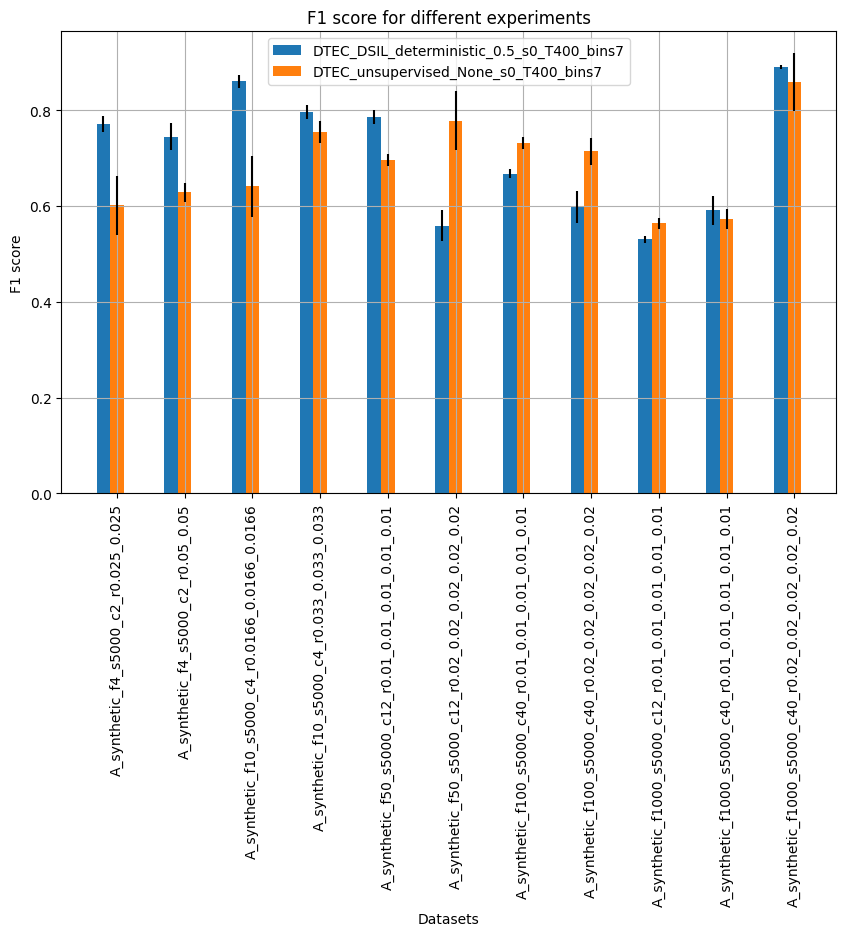

In [21]:
histogram_experiment(mean_df=unsup_bin_mean_df, std_df=unsup_bin_std_df, column="f1_score", ylabel="F1 score", title="F1 score for different experiments")

In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['aucroc_str', 'dataset_name', 'nb_bins']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "nb_bins"], as_index=False).agg({"aucroc_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="nb_bins", values="aucroc_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"nb_bins {col}" for col in df_pivot.columns[1:]]

In [ ]:

latex_str = dataframe_to_latex(df_pivot, caption=f"AUCROC for {METHOD} with different value of nb_bins", label="tab:bin_aucroc", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{AUCROC for unsupervised with different value of nb_bins} \label{tab:bin_aucroc} \begin{tabular}{llll} \toprule dataset name & nb bins 7 & nb bins 16 & nb bins 32 \\ \midrule synthetic 10 - 4.98 & 0.95(0.01) & 0.96(0.01) & 0.92(0.05) \\ synthetic 10 - 9.90 & 0.90(0.01) & 0.90(0.01) & 0.90(0.01) \\ synthetic 100 - 10.00 & 0.91(0.01) & 0.89(0.02) & 0.88(0.02) \\ synthetic 100 - 5.00 & 0.94(0.01) & 0.95(0.01) & 0.65(0.24) \\ synthetic 1000 - 10.00 & 0.89(0.02) & 0.88(0.02) & 0.50(0.00) \\ synthetic 1000 - 5.00 & 0.81(0.03) & 0.83(0.03) & 0.50(0.00) \\ synthetic 4 - 10.00 & 0.78(0.01) & 0.78(0.01) & 0.78(0.01) \\ synthetic 4 - 5.00 & 0.93(0.01) & 0.92(0.01) & 0.92(0.01) \\ synthetic 50 - 10.00 & 0.98(0.01) & 0.99(0.00) & 0.99(0.01) \\ synthetic 50 - 5.00 & 0.86(0.02) & 0.84(0.02) & 0.82(0.02) \\ \bottomrule \end{tabular} \end{table}


/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


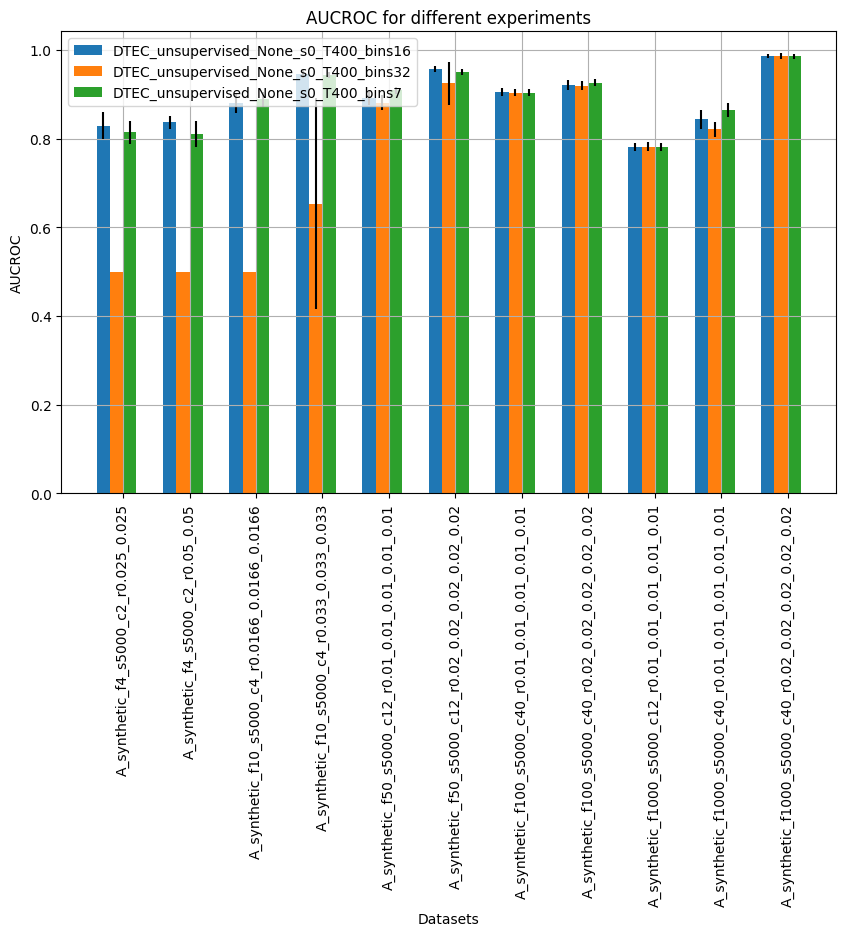

In [ ]:
histogram_experiment(mean_df=unsup_bin_mean_df, std_df=unsup_bin_std_df, column="aucroc", ylabel="AUCROC", title="AUCROC for different experiments")

# T


In [ ]:
unsup_T_mean_df = mean_df[mean_df['training_method'] == METHOD]
unsup_T_mean_df = unsup_T_mean_df[unsup_T_mean_df['nb_bins'] == 16]
unsup_T_std_df = std_df[std_df['training_method'] == METHOD]
unsup_T_std_df = unsup_T_std_df[unsup_T_std_df['nb_bins'] == 16]


In [ ]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(unsup_T_mean_df, unsup_T_std_df, on=["experiment", "dataset_name", "T", "nb_bins"], suffixes=('_mean', '_std'))

# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"{row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})", axis=1
)
merged_df['aucroc_str'] = merged_df.apply(
    lambda row: f"{row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})", axis=1
)
merged_df['dataset_name'] = merged_df['dataset_name'].apply(rename_row)


In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['f1_score_str', 'dataset_name', 'T']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "T"], as_index=False).agg({"f1_score_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="T", values="f1_score_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"T {col}" for col in df_pivot.columns[1:]]

latex_str = dataframe_to_latex(df_pivot, caption=f"F1 score for {METHOD} with different value of T", label="tab:T_f1", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{F1 score for unsupervised with different value of T} \label{tab:T_f1} \begin{tabular}{llll} \toprule dataset name & T 100 & T 200 & T 400 \\ \midrule synthetic 10 - 4.98 & 0.77(0.04) & 0.81(0.03) & 0.80(0.04) \\ synthetic 10 - 9.90 & 0.68(0.05) & 0.74(0.01) & 0.74(0.01) \\ synthetic 100 - 10.00 & 0.65(0.04) & 0.64(0.03) & 0.64(0.04) \\ synthetic 100 - 5.00 & 0.83(0.02) & 0.83(0.02) & 0.80(0.02) \\ synthetic 1000 - 10.00 & 0.51(0.20) & 0.62(0.06) & 0.60(0.06) \\ synthetic 1000 - 5.00 & 0.34(0.20) & 0.65(0.02) & 0.64(0.01) \\ synthetic 4 - 10.00 & 0.56(0.01) & 0.57(0.01) & 0.57(0.01) \\ synthetic 4 - 5.00 & 0.76(0.03) & 0.74(0.03) & 0.72(0.03) \\ synthetic 50 - 10.00 & 0.88(0.02) & 0.88(0.02) & 0.88(0.03) \\ synthetic 50 - 5.00 & 0.52(0.05) & 0.54(0.02) & 0.55(0.02) \\ \bottomrule \end{tabular} \end{table}


/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


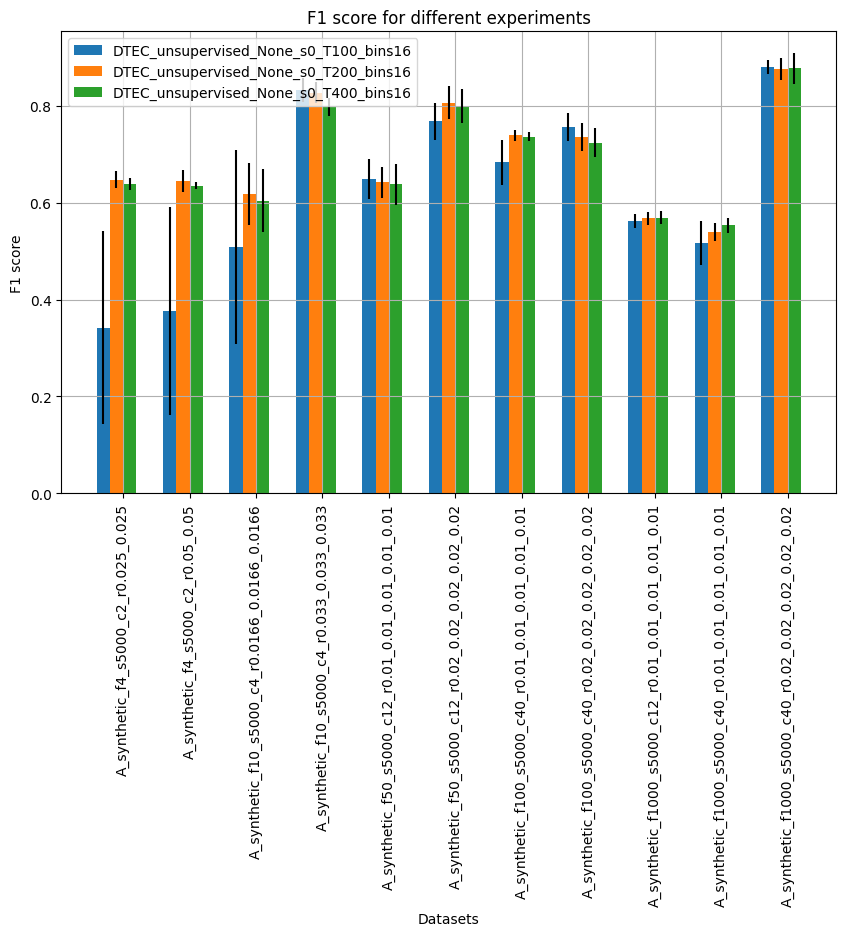

In [ ]:
histogram_experiment(mean_df=unsup_T_mean_df, std_df=unsup_T_std_df, column="f1_score", ylabel="F1 score", title="F1 score for different experiments")

In [ ]:
# Keep in another df f1_score_str, datasetname, nb_bins and experiment
tmp = merged_df[['aucroc_str', 'dataset_name', 'T']]
# Handle duplicates by aggregating (keeping the first entry for each duplicate combination)
df_cleaned = tmp.groupby(["dataset_name", "T"], as_index=False).agg({"aucroc_str": "first"})

# Pivot the cleaned DataFrame
df_pivot = df_cleaned.pivot(index="dataset_name", columns="T", values="aucroc_str").reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the multi-index
df_pivot.columns = ["dataset_name"] + [f"T {col}" for col in df_pivot.columns[1:]]

latex_str = dataframe_to_latex(df_pivot, caption=f"AUCROC for {METHOD} with different value of T", label=f"tab:T_auroc{METHOD}", index=False)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_str)

# Optional: Print the LaTeX table for verification
print(latex_str.replace("\n", " "))

\begin{table}[ht] \centering \caption{AUCROC for unsupervised with different value of T} \label{tab:T_aurocunsupervised} \begin{tabular}{llll} \toprule dataset name & T 100 & T 200 & T 400 \\ \midrule synthetic 10 - 4.98 & 0.95(0.01) & 0.96(0.01) & 0.96(0.01) \\ synthetic 10 - 9.90 & 0.90(0.01) & 0.91(0.01) & 0.90(0.01) \\ synthetic 100 - 10.00 & 0.90(0.02) & 0.89(0.01) & 0.89(0.02) \\ synthetic 100 - 5.00 & 0.96(0.01) & 0.96(0.01) & 0.95(0.01) \\ synthetic 1000 - 10.00 & 0.70(0.15) & 0.84(0.02) & 0.88(0.02) \\ synthetic 1000 - 5.00 & 0.74(0.19) & 0.83(0.02) & 0.83(0.03) \\ synthetic 4 - 10.00 & 0.78(0.01) & 0.78(0.01) & 0.78(0.01) \\ synthetic 4 - 5.00 & 0.93(0.01) & 0.92(0.01) & 0.92(0.01) \\ synthetic 50 - 10.00 & 0.99(0.00) & 0.98(0.01) & 0.99(0.00) \\ synthetic 50 - 5.00 & 0.81(0.03) & 0.82(0.02) & 0.84(0.02) \\ \bottomrule \end{tabular} \end{table}


/home/elouan/code/code_repo/notebooks/utils_notebook.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace("_", " "))


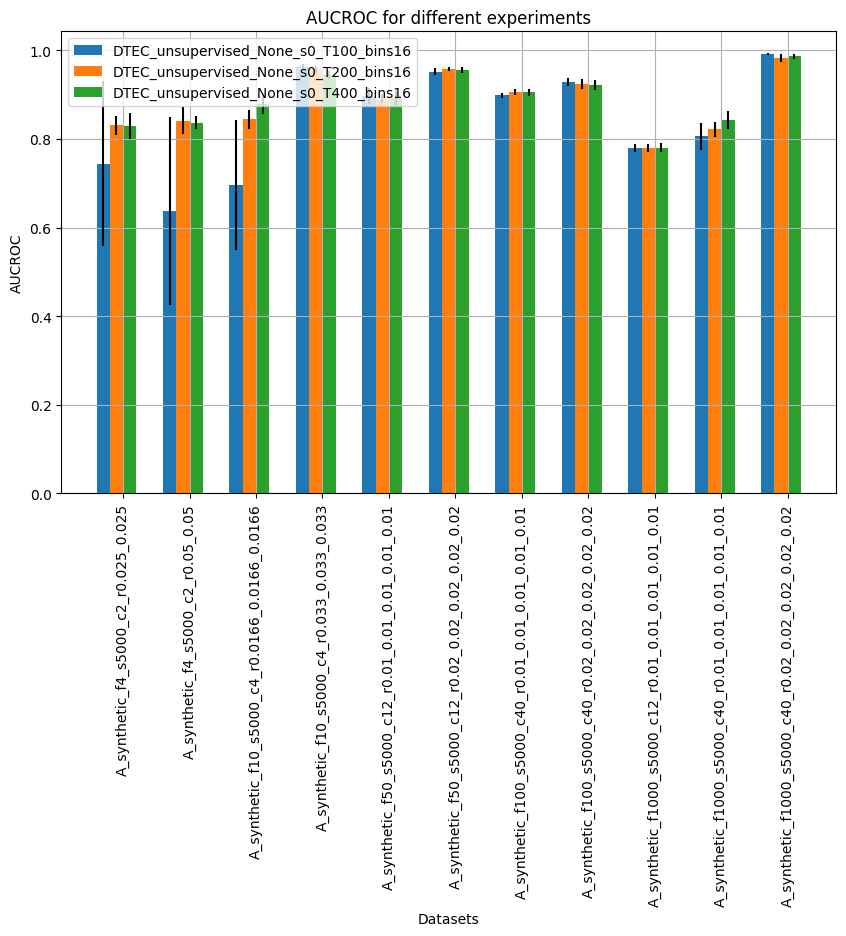

In [ ]:
histogram_experiment(mean_df=unsup_T_mean_df, std_df=unsup_T_std_df, column="aucroc", ylabel="AUCROC", title="AUCROC for different experiments")